In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import fastai
from fastai.vision import *
from fastai.callbacks import SaveModelCallback
import os
#from sklearn.model_selection import KFold
from radam import *
from csvlogger import *
from mish_activation import *
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score,confusion_matrix
import warnings
warnings.filterwarnings("ignore")

fastai.__version__

In [ ]:
sz = 128
bs = 32
nfolds = 4
SEED = 2020
N = 12 #number of tiles per image
TRAIN = '../input/panda-16x128x128-tiles-data/train/'
LABELS = '../input/prostate-cancer-grade-assessment/train.csv'

In [ ]:
df = pd.read_csv(LABELS)

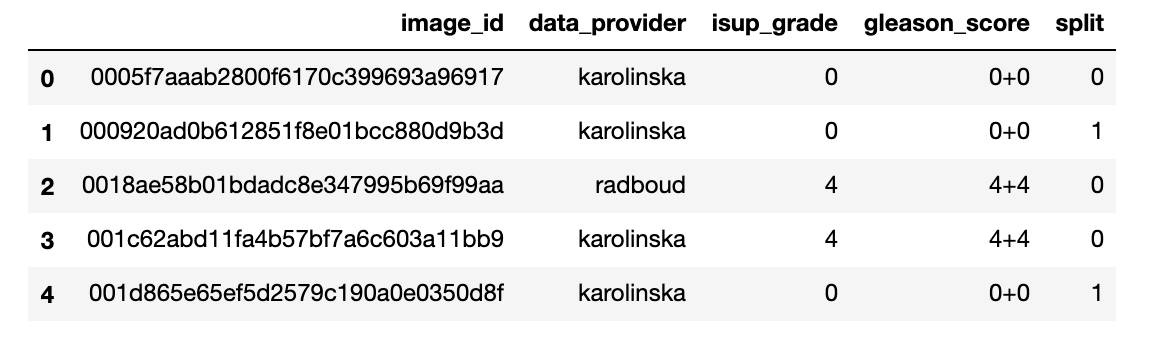

In [ ]:
df = pd.read_csv(LABELS).set_index('image_id')
files = sorted(set([p[:32] for p in os.listdir(TRAIN)]))
df = df.loc[files]
df = df.reset_index()

#データをTrain4つとTest4つに分割している。
splits = StratifiedKFold(n_splits=nfolds, random_state=SEED, shuffle=True)
splits = list(splits.split(df,df.isup_grade))

folds_splits = np.zeros(len(df)).astype(np.int)
for i in range(nfolds): folds_splits[splits[i][1]] = i


df['split'] = folds_splits
df.head()

In [ ]:
mean = torch.tensor([1.0-0.90949707, 1.0-0.8188697, 1.0-0.87795304])
std = torch.tensor([0.36357649, 0.49984502, 0.40477625])

In [ ]:
def open_image(fn:PathOrStr, div:bool=True, convert_mode:str='RGB', cls:type=Image,
        after_open:Callable=None)->Image:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        x = PIL.Image.open(fn).convert(convert_mode)
    if after_open: x = after_open(x)
    x = pil2tensor(x,np.float32)
    if div: x.div_(255)
    return cls(1.0-x) #invert image for zero padding

class MImage(ItemBase):
    def __init__(self, imgs):
        self.obj, self.data = \
          (imgs), [(imgs[i].data - mean[...,None,None])/std[...,None,None] for i in range(len(imgs))]
    
    def apply_tfms(self, tfms,*args, **kwargs):
        for i in range(len(self.obj)):
            self.obj[i] = self.obj[i].apply_tfms(tfms, *args, **kwargs)
            self.data[i] = (self.obj[i].data - mean[...,None,None])/std[...,None,None]
        return self
    
    def __repr__(self): return f'{self.__class__.__name__} {img.shape for img in self.obj}'
    def to_one(self):
        img = torch.stack(self.data,1)
        img = img.view(3,-1,N,sz,sz).permute(0,1,3,2,4).contiguous().view(3,-1,sz*N)
        return Image(1.0 - (mean[...,None,None]+img*std[...,None,None]))

class MImageItemList(ImageList):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def __len__(self)->int: return len(self.items) or 1 
    
    def get(self, i):
        fn = Path(self.items[i])
        fnames = [Path(str(fn)+'_'+str(i)+'.png')for i in range(N)]
        imgs = [open_image(fname, convert_mode=self.convert_mode, after_open=self.after_open)
               for fname in fnames]
        return MImage(imgs)

    def reconstruct(self, t):
        return MImage([mean[...,None,None]+_t*std[...,None,None] for _t in t])
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(300,50), **kwargs):
        rows = min(len(xs),8)
        fig, axs = plt.subplots(rows,1,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()
        

#collate function to combine multiple images into one tensor
def MImage_collate(batch:ItemsList)->Tensor:
    result = torch.utils.data.dataloader.default_collate(to_data(batch))
    if isinstance(result[0],list):
        result = [torch.stack(result[0],1),result[1]]
    return result

In [ ]:
def get_data(fold=0):
    return (MImageItemList.from_df(df, path='.', folder=TRAIN, cols='image_id')
      .split_by_idx(df.index[df.split == fold].tolist())
      .label_from_df(cols=['isup_grade'])
      .transform(get_transforms(flip_vert=True,max_rotate=15),size=sz,padding_mode='zeros')
      .databunch(bs=bs,num_workers=4))

data = get_data(0)
data.show_batch()

In [ ]:
class Model(nn.Module):
    def __init__(self, arch='resnext50_32x4d_ssl', n=6, pre=True):
        super().__init__()
        m = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', arch)
        self.enc = nn.Sequential(*list(m.children())[:-2])       
        nc = list(m.children())[-1].in_features
        self.head = nn.Sequential(AdaptiveConcatPool2d(),Flatten(),nn.Linear(2*nc,512),
                            Mish(),nn.BatchNorm1d(512), nn.Dropout(0.5),nn.Linear(512,n))
        
    def forward(self, *x):
        shape = x[0].shape
        n = len(x)
        x = torch.stack(x,1).view(-1,shape[1],shape[2],shape[3])
        #x: bs*N x 3 x 128 x 128
        x = self.enc(x)
        #x: bs*N x C x 4 x 4
        shape = x.shape
        #concatenate the output for tiles into a single map
        x = x.view(-1,n,shape[1],shape[2],shape[3]).permute(0,2,1,3,4).contiguous()\
          .view(-1,shape[1],shape[2]*n,shape[3])
        #x: bs x C x N*4 x 4
        x = self.head(x)
        #x: bs x n
        return x

In [ ]:
fname = 'RNXT50'
pred,target = [],[]
for fold in range(nfolds):
    data = get_data(fold)
    model = Model()
    learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), opt_func=Over9000, 
                metrics=[KappaScore(weights='quadratic')]).to_fp16()
    logger = CSVLogger(learn, f'log_{fname}_{fold}')
    learn.clip_grad = 1.0
    learn.split([model.head])
    learn.unfreeze()

    learn.fit_one_cycle(16, max_lr=1e-3, div_factor=100, pct_start=0.0, 
      callbacks = [SaveModelCallback(learn,name=f'model',monitor='kappa_score')])
    torch.save(learn.model.state_dict(), f'{fname}_{fold}.pth')
    
    learn.model.eval()
    with torch.no_grad():
        for step, (x, y) in progress_bar(enumerate(data.dl(DatasetType.Valid)),
                                     total=len(data.dl(DatasetType.Valid))):
            p = learn.model(*x)
            pred.append(p.float().cpu())
            target.append(y.cpu())